In [1]:
import pandas as pd
from warnings import simplefilter
import sklearn as sk
import sktime
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
from sktime.utils.plotting import plot_series

In [2]:
#########################################################################
#
# https://www.kaggle.com/sudalairajkumar/covid19-in-india
#
#########################################################################

In [3]:
##
# Will stick with the state of Kerala in India
##

df = pd.read_csv('covid_19_india.csv')
df = df.loc[df['State/UnionTerritory'] == 'Kerala']

df

,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
0,1,2020-01-30,6:00 PM,Kerala,1,0,0,0,1
1,2,2020-01-31,6:00 PM,Kerala,1,0,0,0,1
2,3,2020-02-01,6:00 PM,Kerala,2,0,0,0,2
3,4,2020-02-02,6:00 PM,Kerala,3,0,0,0,3
4,5,2020-02-03,6:00 PM,Kerala,3,0,0,0,3
...,...,...,...,...,...,...,...,...,...
17622,17623,2021-07-29,8:00 AM,Kerala,-,-,3160804,16457,3327301
17658,17659,2021-07-30,8:00 AM,Kerala,-,-,3177453,16585,3349365
17694,17695,2021-07-31,8:00 AM,Kerala,-,-,3192104,16701,3370137
17730,17731,2021-08-01,8:00 AM,Kerala,-,-,3208969,16781,3390761


In [4]:

df = df['Confirmed']


In [5]:
##
# Forcing indices into relative day-gaps. Could reset indices, or just swap from dataframe-> array -> dataframe
# SKtime runs into issues if relative indices have gaps (like we've caused by choosing a specific state)
# 
##
numpy_df = df.to_numpy()
df1 = pd.DataFrame(data=numpy_df, columns=["Cumulative_Confirmed_Covid_Cases"])
Kerala_Covid_series=df1.iloc[:,0]

In [6]:
##
# This will indicate the total number of days. If there are significant day-gaps 
# we should see them immediatly when we plot the cases (double/triple expected)
# 
##
Kerala_Covid_series

0            1
1            1
2            2
3            3
4            3
        ...   
546    3327301
547    3349365
548    3370137
549    3390761
550    3411489
Name: Cumulative_Confirmed_Covid_Cases, Length: 551, dtype: int64

In [7]:
##
# Forecast 55 days ahead
##
fh = np.arange(1, 55)

In [8]:
##
# More-or-less primitive exponential smoothing model. Should fit virus growth better than most
##

from sktime.forecasting.exp_smoothing import ExponentialSmoothing
##
# We assume some weekly seasonal trends. with respect to when people are more liable to get tested. 
# This assumption is only based on Covid experience in Vancouver
# for prediction intervals will use alpha = 0.05 which is about a 2.5 sigma significance
##
alpha = 0.05
forecaster = ExponentialSmoothing(trend='multiplicative',sp = 52)

In [9]:
y_train, y_test = temporal_train_test_split(Kerala_Covid_series, test_size = 0.10)

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Cumulative_Confirmed_Covid_Cases'>)

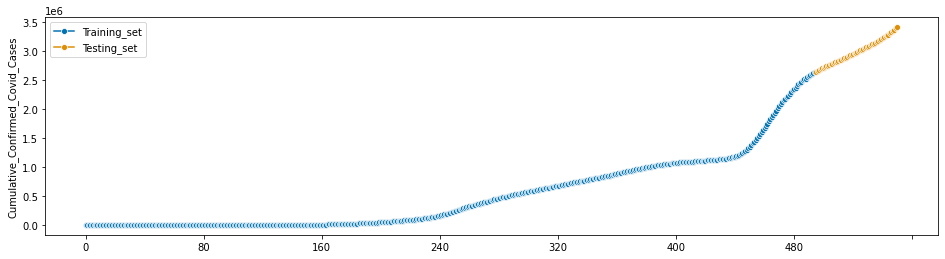

In [10]:
plot_series(y_train,y_test, labels = ['Training_set', 'Testing_set'])

In [11]:
forecaster.fit(y_train)

C:\Users\Parker\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


ExponentialSmoothing(sp=52, trend='multiplicative')

In [13]:
y_pred = forecaster.predict(fh)

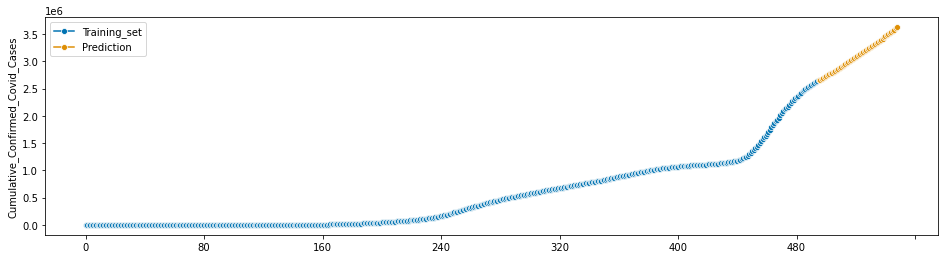

In [14]:
fig, ax = plot_series(y_train, y_pred, labels = ['Training_set', 'Prediction'])

on the 55th day, both the prediction and real data seem to hold agreement within some small percentage, however this is the cumulative covid cases. I suspect the derivative will be more volatile. So lets make it...

In [15]:
Derivative_arr = np.diff(Kerala_Covid_series)
df1 = pd.DataFrame(data=Derivative_arr, columns=["Daily_Confirmed_Covid_Cases"])
Kerala_Derivative=df1.iloc[:,0]

In [16]:
forecaster1 = ExponentialSmoothing ( sp = 52)
yprime_train, yprime_test = temporal_train_test_split(Kerala_Derivative, test_size = 0.10)

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Daily_Confirmed_Covid_Cases'>)

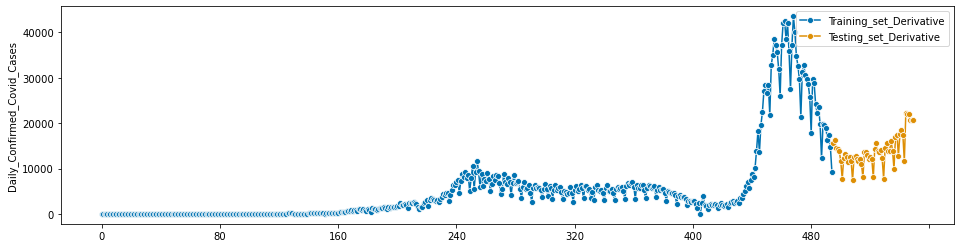

In [17]:
plot_series(yprime_train,yprime_test, labels = ['Training_set_Derivative', 'Testing_set_Derivative'])

Welp. Good luck predicting this one my machine learning friend

In [18]:
forecaster1.fit(yprime_train)
yprime_pred = forecaster1.predict(fh)

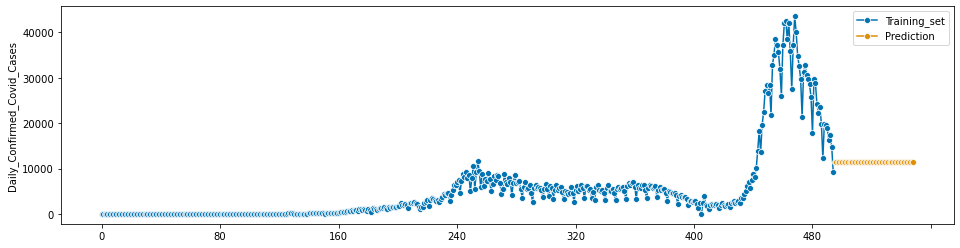

In [19]:
fig, ax = plot_series(yprime_train, yprime_pred, labels = ['Training_set', 'Prediction'])

Well this forecast is pretty bad.... let's test a low order ARIMA model and see what we get

In [20]:
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.arima import ARIMA
##
# Arima with ~ weekly peridicity. Not terrible, but really finnicky. Wouldnt rely on this
##
forecaster2 = ARIMA(order=(2, 1, 0), seasonal_order=(0, 1, 0, 50), suppress_warnings=True)
forecaster2.fit(yprime_train)
yprime_pred, y_ints = forecaster2.predict(fh, return_pred_int=True, alpha = alpha)


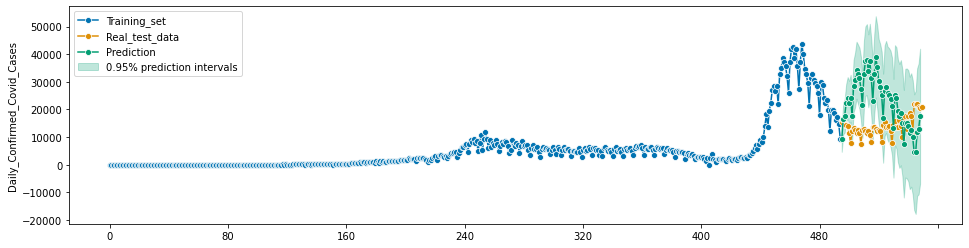

In [50]:
fig, ax = plot_series(yprime_train,yprime_test, yprime_pred, labels = ['Training_set','Real_test_data' ,'Prediction'])
##
# This particular plot settings is taken from
# https://www.sktime.org/en/latest/examples/01_forecasting.html under prediction intervals
##
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    y_ints["lower"],
    y_ints["upper"],
    alpha=0.25,
    color=ax.get_lines()[-1].get_c(),
    label=f"{1 - alpha}% prediction intervals",
)
ax.legend();

These forecasts on the daily cases both suffer from the same problems. When there is a dramatic increase there is an external factor (for example: new variant of covid), and the sharp decreases are caused by vaccine uptake and local policy...

Let's look at the end portion of the graph, with the most recent findings, to have a more consistent external impact to have a more meaningful short-term prediction..

In [23]:
Kerala_Derivative_recent=df1.iloc[450:,0]
fh_recent = np.arange(1, 21)

In [24]:
yprime_train_recent, yprime_test_recent = temporal_train_test_split(Kerala_Derivative_recent, test_size = 0.21)

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Daily_Confirmed_Covid_Cases'>)

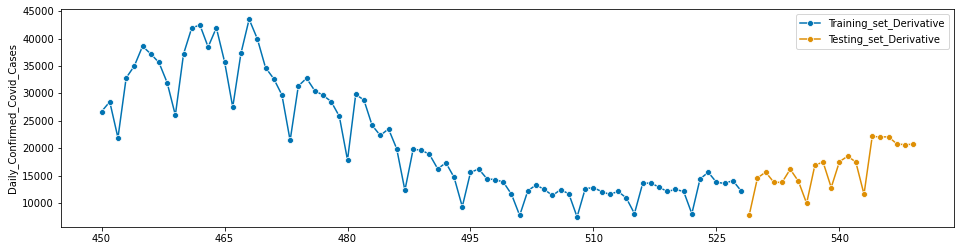

In [25]:
plot_series(yprime_train_recent,yprime_test_recent, labels = ['Training_set_Derivative', 'Testing_set_Derivative'])

In [43]:
forecaster3 = ARIMA(order=(2, 1, 0), seasonal_order=(0, 1, 0, 50), suppress_warnings=True)
forecaster3.fit(yprime_train_recent)
yprime_pred_recent, y_int_recent = forecaster3.predict(fh_recent, return_pred_int=True, alpha = alpha)

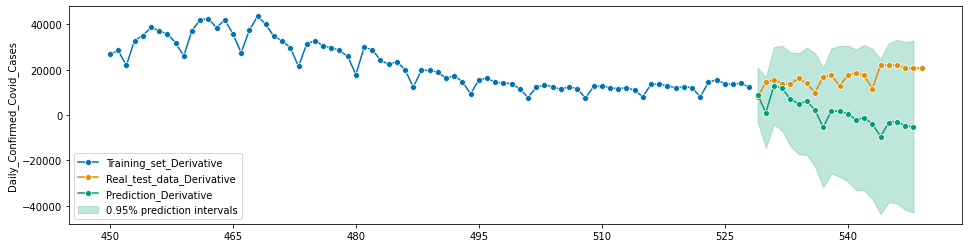

In [51]:
fig2, ax = plot_series(yprime_train_recent,yprime_test_recent ,yprime_pred_recent, labels = ['Training_set_Derivative', 'Real_test_data_Derivative','Prediction_Derivative'])
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    y_int_recent["lower"],
    y_int_recent["upper"],
    alpha=0.25,
    color=ax.get_lines()[-1].get_c(),
    label=f"{1 - alpha}% prediction intervals",
)
ax.legend();

It looks like this ARIMA model isn't getting the whole exponential decay memo, we're dropping below 0 rather fast. It also has no idea where it could end up, given the 95% confidence, the weekly periodicity is captured well, but the general trend is struggling to capture what's going on. this method would probably work well in ensemble with an exponential smoother...

In [52]:
forecaster4 = ExponentialSmoothing (trend="add", sp = 52)
forecaster4.fit(yprime_train_recent)
yprime_pred_recent_exp = forecaster4.predict(fh_recent)


C:\Users\Parker\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


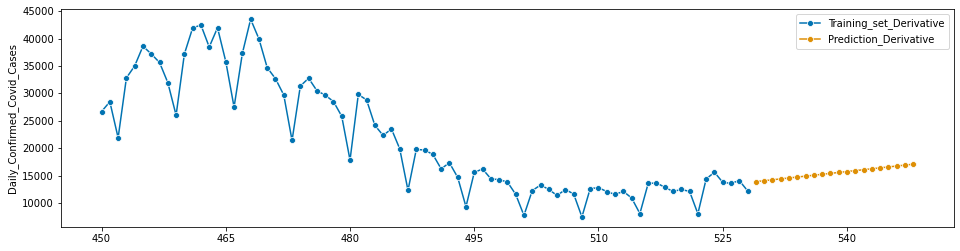

In [54]:
fig2, ax = plot_series(yprime_train_recent, yprime_pred_recent_exp, labels = ['Training_set_Derivative', 'Prediction_Derivative'])

TODO: Ensemble of ARIMA and expo smoothing